In [27]:
import sys, os
sys.path.append("../pattern")

import torch
from torch import nn, tensor, optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, SubsetRandomSampler, WeightedRandomSampler

import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import precision_recall_curve, roc_curve


from Xas2Quality_dataloader import *
from Xas2Quality_model import *
from Xas2Quality_trainer import *

%reload_ext autoreload
%autoreload 1
%aimport Xas2Quality_dataloader, Xas2Quality_model, Xas2Quality_trainer, seaborn

from torch.utils.tensorboard import SummaryWriter

## Reading data and derivative

In [25]:
data_folder = "../large_data/"
spec = Xas2QualityDataset.from_file(spec_file=os.path.join(data_folder,"e7600-8000_grid400_spec_norm.pkl"),
                                    quality_file=os.path.join(data_folder,"e7600-8000_grid400_prediction.pkl"),
                                    energy_cut=(7600,7900))

Orignal Label
1: 4462, 0: 2830, -1: 18386


In [28]:
train_loader, test_loader, val_loader, unlabel_loader = \
        get_Xas2Quality_dataloaders(spec, batch_size=100,unlabel_batch_size=1000)

5104 1093 1095


In [29]:
len(train_loader), len(test_loader), len(val_loader), len(unlabel_loader)

(52, 11, 11, 52)

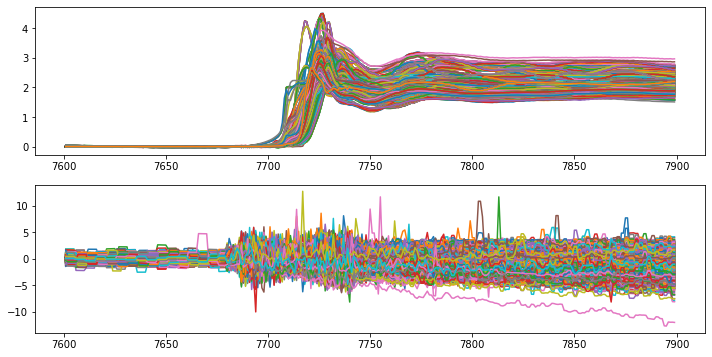

In [12]:
fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].plot(spec.feature, spec.data[(spec.label==1).reshape(-1)].T)
axs[1].plot(spec.feature, spec.data[(spec.label==0).reshape(-1)].T)
plt.show()

#### Some useful links
https://discuss.pytorch.org/t/difference-between-nn-linear-nn-crossentropyloss-and-nn-logsoftmax-nn-nllloss/21634

In [30]:
model = Xas2QualityFCN(input_size=299, output_size=1, dropout_rate=0.4)
Xas2QualityFCN.reset_weights(model.main, verbose=True)

Reset trainable parameters of layer = BatchNorm1d(299, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=299, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=16, bias=True)
Reset trainable parameters of layer = BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


In [31]:
trainer = Trainer(model, train_loader, test_loader, val_loader, loss_constrain_test_loader=unlabel_loader,
                  device=torch.device("cuda"), verbose=True, learning_rate=1e-4,
                  max_epochs=1000, batch_size=100, ts_board=False)

In [ ]:
trainer.train()

Tensorboard is off
Epoch 100/1000 | loss: 0.035/0.017


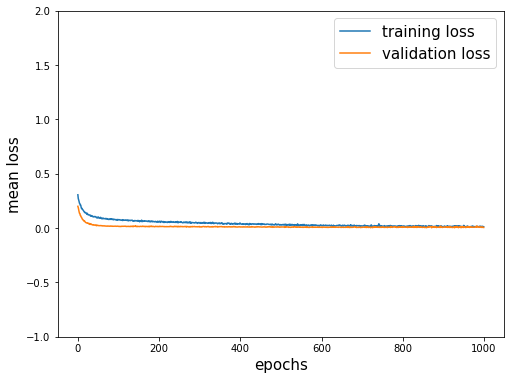

In [148]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
epochs = np.arange(trainer.max_epochs)
ax.plot(epochs,trainer.train_loss,label='training loss')
ax.plot(epochs,trainer.val_loss,label='validation loss')
ax.set_xlabel('epochs',fontsize=15)
ax.set_ylabel('mean loss',fontsize=15)
ax.legend(fontsize=15)
ax.set_ylim([-1,2])
plt.show()

In [316]:
y_score = []
x_test = []
y_test = []
for x, y in test_loader:
    score = trainer.model(x.to(device).float())
    x_test.append(x.detach().cpu().numpy())
    y_test.append(y.detach().cpu().numpy())
    y_score.append(score.detach().cpu().numpy())
x_test = np.vstack(x_test)
y_test = np.vstack(y_test)
y_score = np.vstack(y_score)

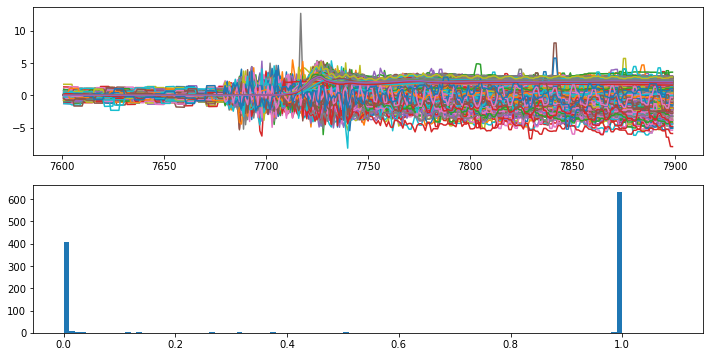

In [188]:
fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].plot(spec.feature, x_test.T)
axs[1].hist(y_score,bins=np.arange(0,1.1,0.01),color='tab:blue')
plt.show()

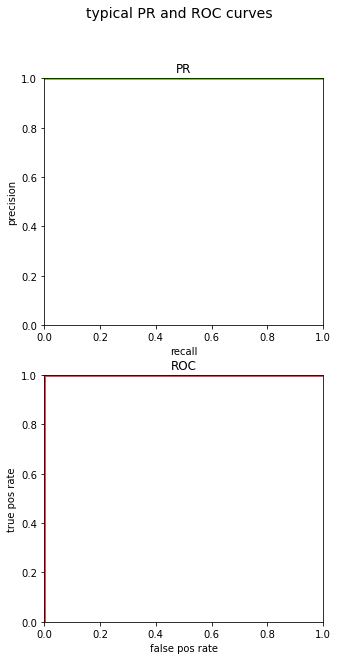

In [190]:
GREEN = '#72d218'
RED = '#f4424b'
BLUE = '#72bdff'


def label_plot(ax, is_pr=True):
    x, y = (('recall', 'precision')
            if is_pr else
            ('false pos rate', 'true pos rate'))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    
def plot_pr_and_roc(y_true, y_pred, title):
    p, r, _ = precision_recall_curve(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    fig, axs = plt.subplots(2, 1, figsize=(5,10))
    axs[0].plot(r, p, lw=4, color=GREEN)
    axs[0].set_title('PR')
    label_plot(axs[0], is_pr=True)

    axs[1].plot(fpr, tpr, lw=4, color=RED)
    axs[1].set_title('ROC')
    label_plot(axs[1], is_pr=False)

    fig.suptitle(title, fontsize=14)
    
plot_pr_and_roc(y_test, y_score, title='typical PR and ROC curves')

638/1095


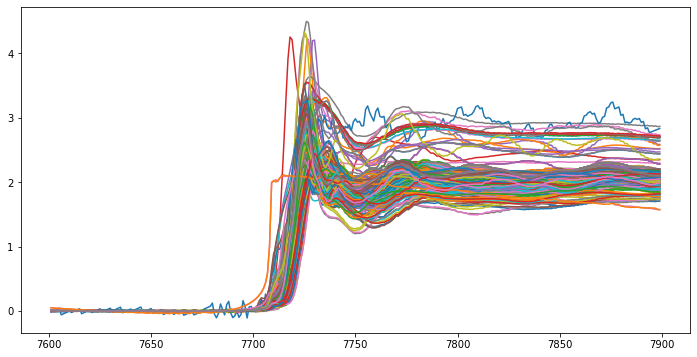

In [331]:
plot_select = (y_score > 0.8).reshape(-1)
fig, ax = plt.subplots(figsize=(12,6))
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))
for i,d in enumerate(x_test[plot_select]):
    ax.plot(spec.feature, d)
# ax.set_xlim([7700,7740])

20/1095


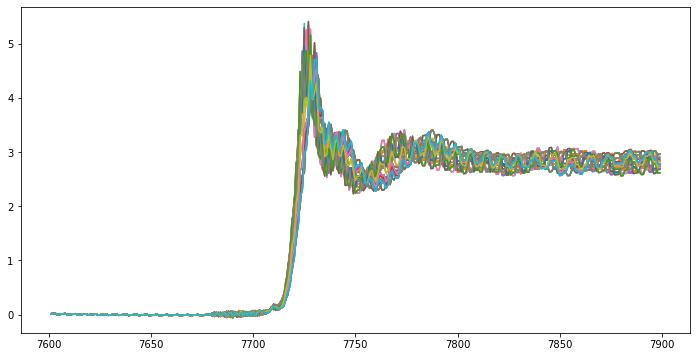

In [319]:
plot_select = ((y_score > 0.2) & (y_score <= 0.8)) .reshape(-1)
fig, ax = plt.subplots(figsize=(12,6))
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))
random_select = list(np.random.randint(plot_select.sum(),size=50))
for i,d in enumerate(x_test[plot_select][random_select]):
    ax.plot(spec.feature, d)

437/1095


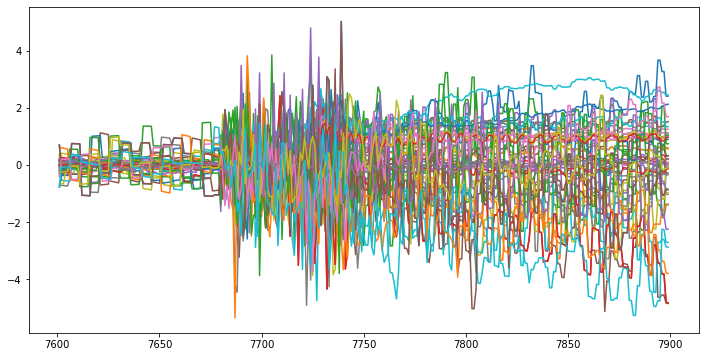

In [334]:
plot_select = (y_score <=0.2).reshape(-1)
random_select = np.random.randint(plot_select.sum(),size=50)
fig, ax = plt.subplots(figsize=(12,6))
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))
for i,d in enumerate(x_test[plot_select][random_select]):
    ax.plot(spec.feature, d)

In [337]:
unlabeled = (spec.spec_label == -1).flatten()
x_unlabel = spec.spec[unlabeled]
y_unlabel = spec.spec_label[unlabeled]

In [338]:
y_score1 = trainer.model(tensor(x_unlabel).to(device).float())
y_score1 = y_score1.detach().cpu().numpy()
random_select = list(np.random.randint(len(y_score1),size=200))

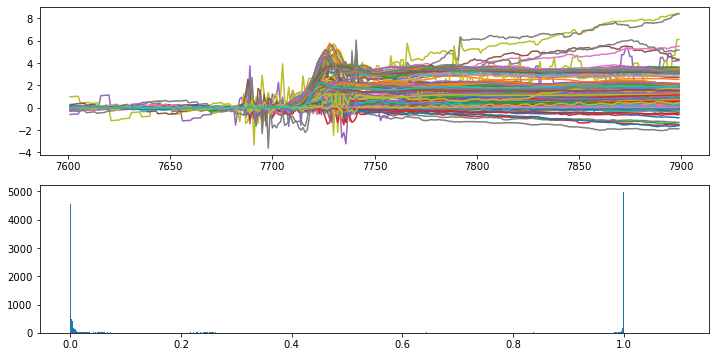

In [339]:
fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].plot(spec.feature, x_unlabel[random_select].T)
axs[1].hist(y_score1,bins=np.arange(0,1.1,0.001))
plt.show()

6184/18386


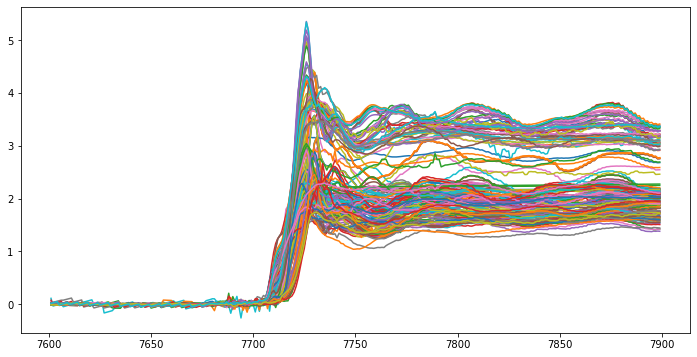

In [273]:
plot_select = ((y_score1 > 0.9) & (y_score1 <= 1.0)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=200))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(x_unlabel[plot_select][random_select]):
    ax.plot(spec.feature, d)

373/18386


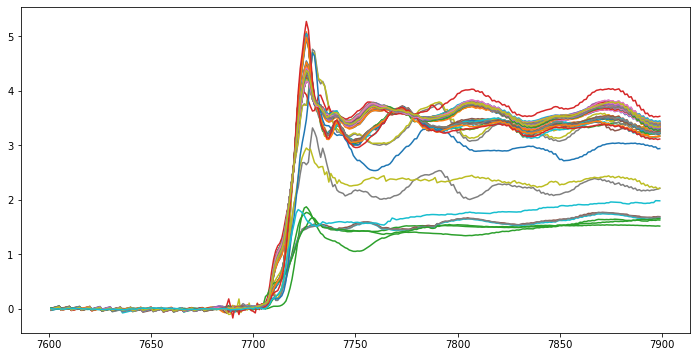

In [278]:
plot_select = ((y_score1 > 0.8) & (y_score1 <= 0.9)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=100))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(x_unlabel[plot_select][random_select]):
    ax.plot(spec.feature, d)

6214/18386


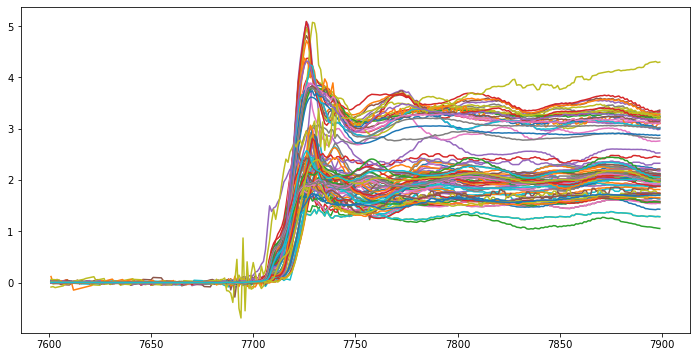

In [156]:
plot_select = ((y_score1 > 0.9) & (y_score1 <= 1.0)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=200))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(x_unlabel[plot_select][random_select]):
    ax.plot(spec.feature, d)

7504/18386


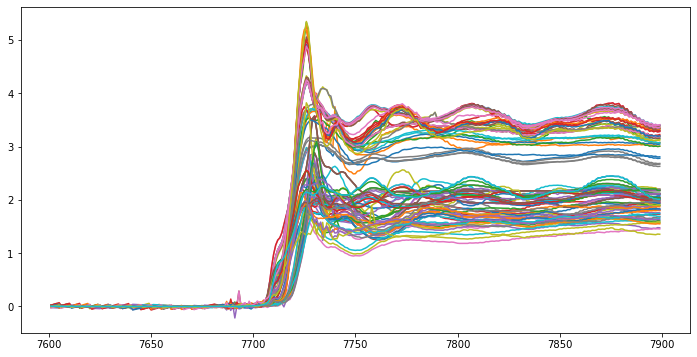

In [88]:
plot_select = ((score > 0.9) & (score <= 1.0)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=100))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(data_to_pred[plot_select].detach().cpu().numpy()[random_select]):
    ax.plot(spec.feature, d)

1313/18386


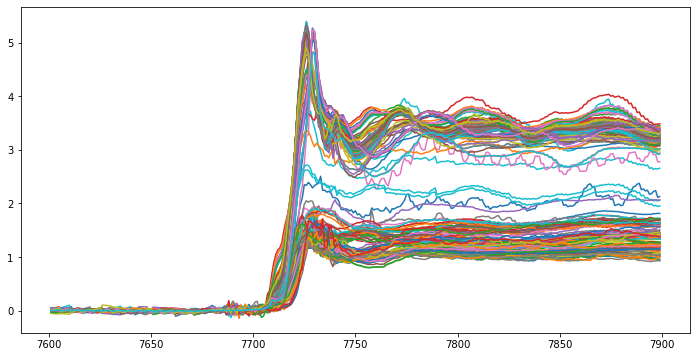

In [290]:
plot_select = ((y_score1 > 0.5) & (y_score1 <= 0.8)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=200))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(x_unlabel[plot_select][random_select]):
    ax.plot(spec.feature, d)

1246/18386


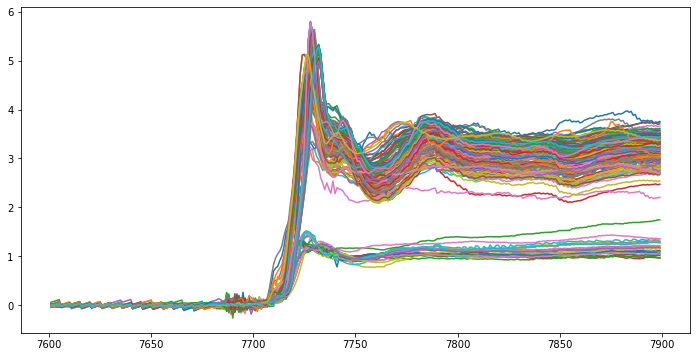

In [289]:
plot_select = ((y_score1 > 0.2) & (y_score1 <= 0.5)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=200))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(x_unlabel[plot_select][random_select]):
    ax.plot(spec.feature, d)

239/18386


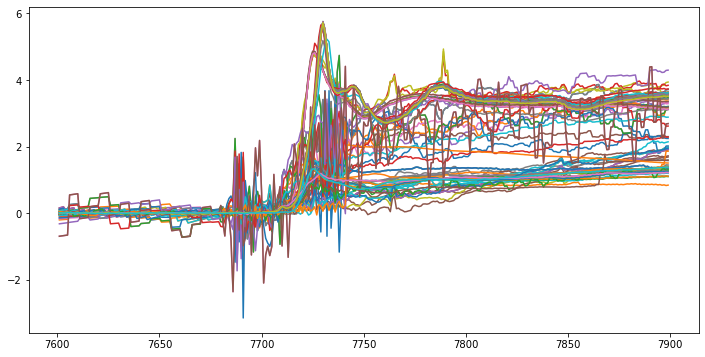

In [313]:
plot_select = ((y_score1 > 0.1) & (y_score1 <= 0.2)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=100))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(x_unlabel[plot_select][random_select]):
    ax.plot(spec.feature, d)

9030/18386


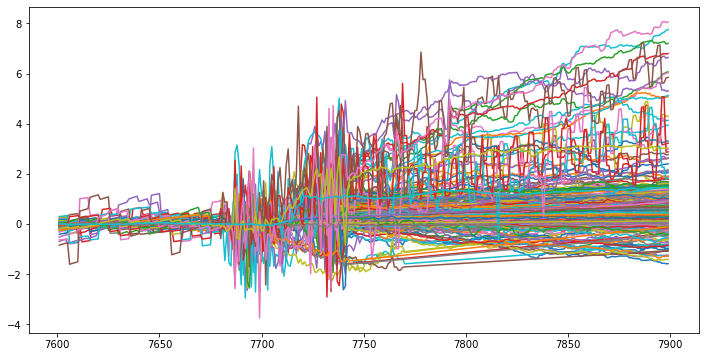

In [314]:
plot_select = ((y_score1 > 0.) & (y_score1 <= .1)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=200))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(x_unlabel[plot_select][random_select]):
    ax.plot(spec.feature, d)

In [207]:
# N_sample = len(data)
# index = np.arange(N_sample)
# test_mask = ~(masks['good']|masks['bad'])

# # label score (1 or 0) or predicted scores for all the data
# labels = np.zeros(N_sample,dtype=float)
# labels[masks['good']] = int(1)
# labels[masks['bad']] = int(0)
# labels[index[test_mask]] = y_test_pred.reshape(-1)

# # train/test label for all the date
# sets = ['train'] * N_sample
# for i in index[test_mask]: sets[i] = 'test'

# result = {'set': sets,
#           'label': labels}

# with open("e{}-{}_grid400_prediction.pkl".format(int(norm_left),int(norm_right)),'wb') as f:
#     pickle.dump(result,f)